# **Lightning Strikes 5**

We will be examining lightning strike data collected by the National Oceanic and Atmospheric Association (NOAA) from 1987 through 2020. Because this would be many millions of rows to read into the notebook, we've preprocessed the data so it contains just the year and the number of strikes.

We will examine the range of total lightning strike counts for each year and identify outliers. Then we will plot the yearly totals on a scatterplot.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('/Users/timothypark/Documents/portfolios/timpark99.github.io/Lightning Strikes 5/eda_outliers_dataset1.csv')

In [6]:
df.head()

,year,number_of_strikes
0,2020,15620068
1,2019,209166
2,2018,44600989
3,2017,35095195
4,2016,41582229


Next, let's convert the number of strikes value to a more readable format on the graph (e.g., converting 100,000 to 100K, 3,000,000 to 3M, and so on).

In [8]:
def readable_numbers(x):
    """takes a large number and formats it into K,M to make it more readable"""
    if x >= 1e6:
        s = '{:1.1f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s

# Use the readable_numbers() function to create a new column 
df['number_of_strikes_readable']=df['number_of_strikes'].apply(readable_numbers)
df.head()

,year,number_of_strikes,number_of_strikes_readable
0,2020,15620068,15.6M
1,2019,209166,209K
2,2018,44600989,44.6M
3,2017,35095195,35.1M
4,2016,41582229,41.6M


In [9]:
print("Mean:" + readable_numbers(np.mean(df['number_of_strikes'])))
print("Median:" + readable_numbers(np.median(df['number_of_strikes'])))

Mean:26.8M
Median:28.3M


A boxplot can help to visually break down the data into percentiles / quartiles, which are important summary statistics. The shaded center of the box represents the middle 50th percentile of the data points. This is the interquartile range, or IQR. 

The boxplot "whiskers" extend 1.5x the IQR by default.

/var/folders/5z/f5jycvmd0x58dvn1by8xk79h0000gn/T/ipykernel_93289/408997470.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  box.set_xticklabels(np.array([readable_numbers(x) for x in g.get_xticks()]))


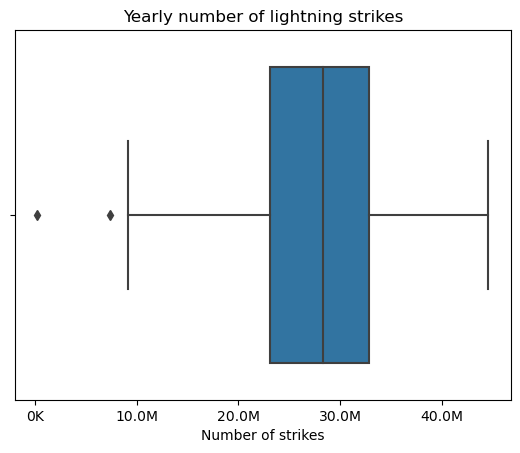

In [11]:
# Create boxplot
box = sns.boxplot(x=df['number_of_strikes'])
g = plt.gca()
box.set_xticklabels(np.array([readable_numbers(x) for x in g.get_xticks()]))
plt.xlabel('Number of strikes')
plt.title('Yearly number of lightning strikes');

The points to the left of the left whisker are outliers. Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers.

One important point for every data professional: do not assume an outlier is erroneous unless there is an explanation or reason to do so.

Let's define our IQR, upper, and lower limit.

In [13]:
# Calculate 25th percentile of annual strikes
percentile25 = df['number_of_strikes'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = df['number_of_strikes'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print('Lower limit is: '+ readable_numbers(lower_limit))

Lower limit is: 8.6M


Now we can use a Boolean mask to select only the rows of the dataframe where the number of strikes is less than the lower limit we calculated above. These rows are the outliers on the low end.

In [15]:
# Isolate outliers on low end
df[df['number_of_strikes'] < lower_limit]

,year,number_of_strikes,number_of_strikes_readable
1,2019,209166,209K
33,1987,7378836,7.4M


Let's get a visual of all of the data points with the outlier values colored red.

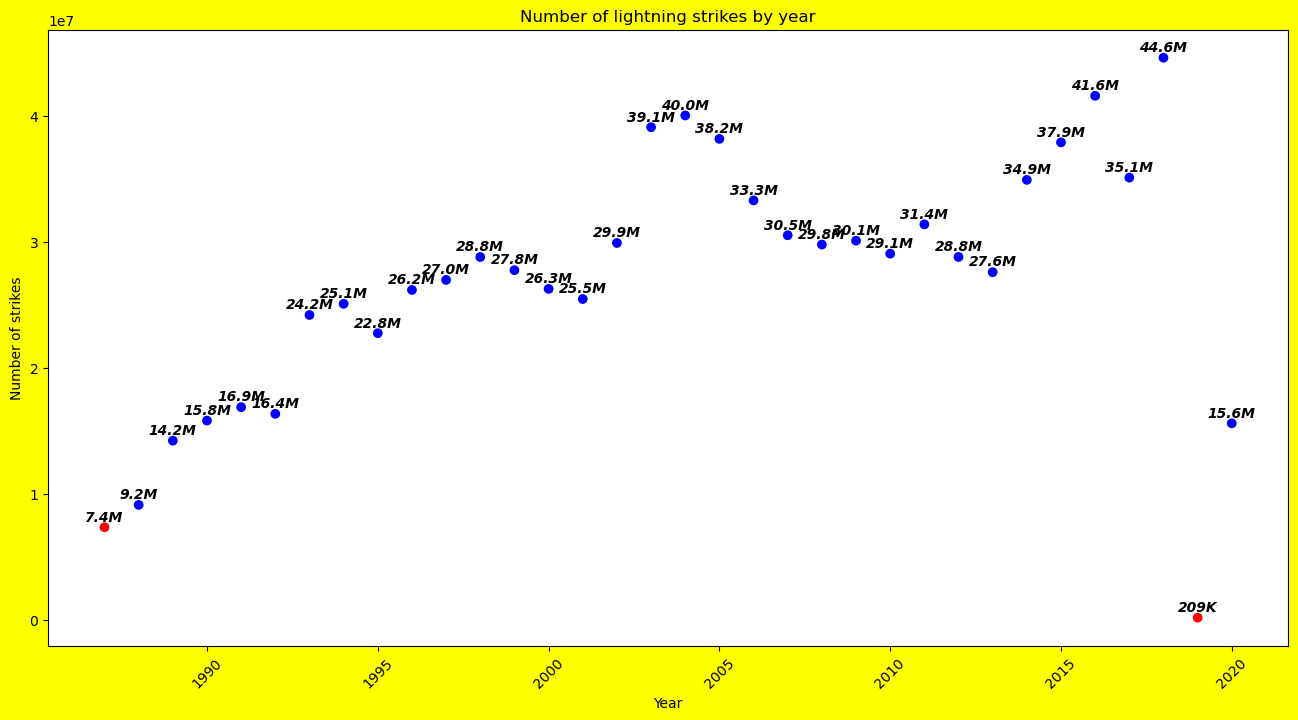

In [80]:
# plt.text has 3 main inputs which is the x and y position and what you want to be placed on the graph
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], y[i]+500000, readable_numbers(y[i]), ha='center', fontsize=10, fontweight='bold', fontstyle='italic')

# 3 parameters in 'np.where' - condition, if true then x, if false then y
colors = np.where(df['number_of_strikes'] < lower_limit, 'r', 'b')

# fig is the canvas you're drawing on
fig, ax = plt.subplots(figsize=(16,8))
fig.set_facecolor('yellow')
ax.scatter(df['year'], df['number_of_strikes'],c=colors)
ax.set_xlabel('Year')
ax.set_ylabel('Number of strikes')
ax.set_title('Number of lightning strikes by year')
addlabels(df['year'], df['number_of_strikes'])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

### Investigating the outliers 2019 and 1987

Let's examine the two outlier years a bit more closely. In the section above, we used a preprocessed dataset that didn't include a lot of the information that we're accustomed to having in this data. In order to further investigate the outlier years, we'll need more information, so we're going to import data from these years specifically.

In [85]:
df_2019 = pd.read_csv('/Users/timothypark/Documents/portfolios/timpark99.github.io/Lightning Strikes 5/eda_outliers_dataset2.csv')

In [87]:
df_2019.head()

,date,number_of_strikes,center_point_geom
0,2019-12-01,1,POINT(-79.7 35.3)
1,2019-12-01,1,POINT(-84.7 39.3)
2,2019-12-01,1,POINT(-83.4 38.9)
3,2019-12-01,1,POINT(-71.5 35.2)
4,2019-12-01,1,POINT(-87.8 41.6)


First, we'll convert the `date` column to datetime. This will enable us to extract two new columns: `month` and `month_txt`. Then, we'll sort the data by `month` and `month_txt`, sum it, and sort the values. 

In [92]:
# Convert `date` column to datetime
df_2019['date']= pd.to_datetime(df_2019['date'])

# Create 2 new columns
df_2019['month'] = df_2019['date'].dt.month
df_2019['month_txt'] = df_2019['date'].dt.month_name().str.slice(stop=3)

# Group by `month` and `month_txt`, sum it, and sort. Assign result to new df
df_2019_by_month = df_2019.groupby(['month','month_txt']).sum(numeric_only=True).sort_values('month', ascending=True).head(12).reset_index()
df_2019_by_month

,month,month_txt,number_of_strikes
0,12,Dec,209166


2019 appears to have data only for the month of December. The likelihood of there not being any lightning from January to November 2019 is ~0. This appears to be a case of missing data. We should probably exclude 2019 from the analysis (for most use cases).

#### Import data for 1987

Now let's inspect the data from the other outlier year, 1987.


In [96]:
# Read in 1987 data
df_1987 = pd.read_csv('/Users/timothypark/Documents/portfolios/timpark99.github.io/Lightning Strikes 5/eda_outliers_dataset3.csv')

In this code block we will do the same datetime conversions and groupings we did for the other datasets. 

In [101]:
# Convert `date` column to datetime
df_1987['date'] = pd.to_datetime(df_1987['date'])

# Create 2 new columns
df_1987['month'] = df_1987['date'].dt.month
df_1987['month_txt'] = df_1987['date'].dt.month_name().str.slice(stop=3)

# Group by `month` and `month_txt`, sum it, and sort. Assign result to new df
df_1987_by_month = df_1987.groupby(['month','month_txt']).sum(numeric_only=True).sort_values('month', ascending=True).head(12).reset_index()
df_1987_by_month

,month,month_txt,number_of_strikes
0,7,Jul,1470566
1,8,Aug,1324502
2,9,Sep,478188
3,10,Oct,62981
4,11,Nov,70912
5,12,Dec,24015


1987 has data for every month of the year (I deleted Jan-June because of size issues). Hence, this outlier should be treated differently than 2019, which is missing data. 

Finally, let's re-run the mean and median after removing the outliers. Our final takeaway from our lesson on outliers is that outliers significantly affect the dataset's mean, but do not significantly affect the median. 

To remove the outliers, we'll use a Boolean mask to create a new dataframe that contains only the rows in the original dataframe where the number of strikes >= the lower limit we calculated above.

In [104]:
# Create new df that removes outliers
df_without_outliers = df[df['number_of_strikes'] >= lower_limit]

# Recalculate mean and median values on data without outliers
print("Mean:" + readable_numbers(np.mean(df_without_outliers['number_of_strikes'])))
print("Median:" + readable_numbers(np.median(df_without_outliers['number_of_strikes'])))

Mean:28.2M
Median:28.8M


Both the mean and the median changed, but the mean much more so. It is clear that outlier values can affect the distributions of the data and the conclusions that can be drawn from them.